In [19]:
# Libraries 
import numpy as np
from numpy import random
import math 
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import time 
from time import time
import matplotlib.backends.backend_pdf

In [20]:
total_maximum_time = 2 # float(input("What time do you want to use?"))

# This is alpha in the alpha Ricatti equuation when it's not one
# can alpha be a float?
t_scale = 1 # int(input("What max waiting time would you like to use [seconds]?"))

# implementing a max time safety [seconds] 
t_safe = 5 # float(input("What max waiting time would you like to use [seconds]?"))
#0.000001

num_iterations = int(3)# int(input("How many iterations would you like for each set of experiments?"))
comparison_points  = int(2)# at most 5, as currently how many distint markers there are for plots below. 
# int(input("How many comparison runs do you want to run?"))

theory_points = int(4) # rounds down, ex: 4.6 = 4
#theory_points = int(input("How many time intervals do you want?")) # float(input("How many theory points would you like to use?"))

t_width = round(total_maximum_time / theory_points, 2) #should round this for all through out


In [21]:
# Arrays to store informations for numerous loops 
def initiate_arrays():
    global Datas, Nodes, colors, u_array, markers 
    global hyperexploding, last_gen_leaves_exp, last_gen_leaves_ended, non_last_gen_leaves_ended, leaves_ended
    # Theses variables are now global
    
    Datas = np.array([]) # stores template information of each node
    Nodes = np.array([]) 
    # would like to automate and asjust colors based on number of max generations obtained
    colors = np.array(['green', 'blue', 'orange', 'cyan', 'magenta', 'slategray', 'red', 'lime', 'brown', 'hotpink', 
                       'green', 'blue', 'orange', 'cyan', 'magenta', 'slategray', 'red', 'lime', 'brown', 'hotpink', 
                       'green', 'blue', 'orange', 'cyan', 'magenta', 'slategray', 'red', 'lime', 'brown', 'hotpink']) 
    u_0 = np.array ([0.0, .1, 0.5, 0.8, 1.0, 1.1, 1.5]) # all
    #u_0 = np.array([0, 0.1, 0.5, 0.8, 1.0]) # 0-1
    # u_0 = np.array([1.0, 1.1, 1.5]) # <1
    u_array = u_0 # initial value conditions
    markers = np.array(['o', 'X', 'v' ,'p', 'd', '3', '*'])
   
    # need to split matrix to store these per num of iterations and comparison points?
    hyperexploding = np.array([])
    last_gen_leaves_exp =  np.array([]) 
    last_gen_leaves_ended =  np.array([]) 
    non_last_gen_leaves_ended =  np.array([]) 
    leaves_ended = np.array([]) 
    
    
    
    for i in range(theory_points + 1): 
        beta = round((t_width*i), 2) # beta dummy variable to iterate through incremental spaces
        globals()[f"u_T{beta+t_width}"] = np.array([])
        globals()[f"u_T_sums{beta+t_width}"] = np.array([])
      

In [22]:
#initializing arays
def initialize():
    global generation, data, lev, d_point
    
    #All these get re-initialized every iteration
    generation = 0 # the level of the node(s), passed to the data template
    data = np.array([]) # storing the template information for each node
    lev = np.array([]) # stores number of nodes for each generation 
    d_point = 0 # To keep track of parents
    
    for i in range(theory_points + 1): 
        beta = round((t_width*i), 2) # beta dummy variable to iterate through incremental spaces
        globals()[f"data_T{beta + t_width}"] = np.array([])  
    

In [23]:
# These are the templates used to store information for eah node in the 'data' array
class Start_Node: # for base case
    def __init__(self, generation, t_max):
        self.generation = generation
        self.duration = random.exponential(scale=1.0, size =1 ) / (t_scale ** generation)
        self.t_remaining = t_max - self.duration[0] # check convention vs int(self.duration)
        # print(self.generation, self.t_remaining)
        self.location = np.array([0])
        if self.t_remaining > 0:
            self.procreate = True #branch
        else:
            self.procreate = False
            #print('not if')
            
class Node: #for all subsequent node
    def __init__(self, generation, t_rem_parent, d_point, k): 
        # If d_point & others are global, do they need to be passed in?? unsure for python 'class' protocol.
        self.generation = generation 
        self.duration = random.exponential(scale=1.0, size =1 ) / (t_scale** self.generation)
        #print('duration', self.duration) - this is an array from for some reason
        self.t_remaining = t_rem_parent - self.duration[0] 
        self.parent_location = d_point
        if k == 0 :
            self.location = np.append(data[d_point].location, k - 1)
        else:
            self.location = np.append(data[d_point].location, k)   
        if self.t_remaining > 0:
            self.procreate = True
        else:
            self.procreate = False
            

In [24]:
def base_case(): # Initializing base case
    global generation, data, lev # Need to list any varaible that we are changing globally.
    data = np.append(data, Start_Node(generation, total_maximum_time))
    if data[-1].procreate == False:
        lev = np.append(lev, 0) # zero nodes were created 
    else:
        lev = np.append(lev, 1) #adds the node to the lev array
        t =  data[d_point].t_remaining # grab the parent time remaining 
        gen = 0 # This is a counter to record how many nodes will have in the next generation 
        generation = generation + 1 # Move to the next generation for child creation
        for k in range (2): # need two children 
            data = np.append(data, Node(generation, t, d_point, k) )
            if data[-1].procreate == True:
                gen += 1 # track the number of nodes to create children for in the subsequent generation
        lev = np.append(lev, gen) # Nuber of nodes (that proreate) per generation 
        

In [25]:
# iterative computational loop
def iterative_loop():
    global lev, d_point, data, generation
    # lev contains by geneartion the number of nodes that will procreate in the subsequent generation 
    generation = generation + 1 # Move to the next level
    if int(lev[-1]) != 0: # Run while the number of children appended is not zero 
                gen = 0 # reset the node count tracker to fill the lev array
                d_point = int(2*(sum(lev[:-2])) ) #adds from zero until the last two entries of lev
                for i in range(int(lev[-1])): # grabs last value in our lev array, which has number of nodes at each level    
                    d_point = d_point + 1  # points at parent location for which need to create children (which will be appended at the end of data array)
                    #print('d_oint', d_point)
                    while data[d_point].procreate == False: # If  the 'parent' timed out and no new nodes need to be made,  
                        d_point += 1 # move to the next (node in the same level)
                    if data[d_point].procreate == True:
                        t =  data[d_point].t_remaining # grab the parent time remaining 
                        #print('parent location', d_point)
                        #print('time left', t)
                        for k in range (2): # need two children 
                            #print('generation', generation)
                            data = np.append(data, Node(generation, t, d_point, k))
                            if data[-1].procreate == True:
                                gen += 1 # record how many nodes (vs leaves) will have in the next generation
                                #print('gen', gen)      
                lev = np.append(lev, gen) # add how many nodes were created in the cubsequent level into our 'lev' array.
               

In [26]:
def buckets():
    # Places nodes where they end, checking from the last bin (total max time elapsed + t_width) to the first. 
    for i in range (len(data)):    
        for j in range(theory_points +1):
            beta = round(t_width*j,2)
            if data[i].t_remaining < beta:
                globals()[f"data_T{total_maximum_time + t_width - beta}"] = np.append(globals()[f"data_T{total_maximum_time + t_width - beta}"], data[i])
                break
    # Start with t_width all the way to (t_max +t_width) = end of tree.
    template = 0
    for i in range(theory_points+1):
        beta = round(t_width*i, 2)
        globals()[f"u_T{beta+t_width}"] = np.append(globals()[f"u_T{beta+t_width}"], int(len(globals()[f'data_T{beta+t_width}'])))
        template = np.add(template, globals()[f"u_T{beta+t_width}"][-1])
        globals()[f"u_T_sums{beta+t_width}"] = np.append(globals()[f"u_T_sums{beta+t_width}"], template)
            

In [27]:
def count_leaves():
    global Datas, Nodes, last_gen_leaves_exp, last_gen_leaves_ended, non_last_gen_leaves_ended, hyperexploding, leaves_ended
    Datas = np.append(Datas, len(data))   # Datas = 2*Levels + 1
    Nodes = np.append(Nodes, sum(lev))  
    leaves_cont = 1
    for p in range (theory_points):  
        beta = round(t_width*p,2)
        last_gen_exploded = 0
        last_gen_ended = 0
        non_last_gen_ended = 0
        z = 0 
        for z in range (int(globals()[f"u_T{beta+t_width}"][-1])): 
            if globals()[f"data_T{beta+t_width}"][z].generation == data[-1].generation:
                if globals()[f"data_T{beta+t_width}"][z].procreate == True:
                    last_gen_exploded += 1 
            else:    
                non_last_gen_ended += 1
                        
        leaves_cont = leaves_cont +len(globals()[f"data_T{beta+t_width}"]) - (2*last_gen_exploded)
        leaves_ended = np.append(leaves_ended, leaves_cont)
        last_gen_leaves_exp =  np.append(last_gen_leaves_exp, last_gen_exploded)
        non_last_gen_leaves_ended = np.append(non_last_gen_leaves_ended, non_last_gen_ended)
        last_gen_leaves_ended = np.append(last_gen_leaves_ended, last_gen_ended)
        # Need a way to gather how many from last generation ended
        """
        print("Printitng tree from ", round((beta+t_width),2), " bucket.")
        print("leaves_cont", leaves_cont)
        print("new nodes ", globals()[f"u_T{beta+t_width}"][-1])
        print("nodes exploded in last generation ", last_gen_exploded) # equivalent to last spot of lev
        print("nodes non_last_gen ticked",  non_last_gen_ended)
        """
 
    hyperexploding =  np.append(hyperexploding, sum(last_gen_leaves_exp))   #do wereally want to add this here?
    #print('hyperexplodign', hyperexploding)

    

In [28]:
def evolution_tree(exp_num_iterations):
    #plt.scatter(10, data[0].t_remaining, c = 'black') 
    fig = plt.figure()
    for i in range (theory_points+1):
        beta = round(t_width*i, 2)
        x_axis = np.array([])
        y_axis = np.array([])
        gen_colors  = np.array([])
        for j in range (int(globals()[f"u_T{beta+t_width}"][-1])):
            x = 0
            for k in range (globals()[f"data_T{beta+t_width}"][j].generation):
                x = x + (globals()[f"data_T{beta+t_width}"][j].location[k+1])*((1/2)**(k+1))*10
            x_axis = np.append(x_axis, x)
            y_axis = np.append(y_axis, globals()[f"data_T{beta+t_width}"][j].t_remaining)
            gen_colors = np.append(gen_colors, colors[int(globals()[f"data_T{beta+t_width}"][j].generation)])
        plt.scatter(np.add(x_axis,10), y_axis, c = gen_colors)
    plt.title('Evolution of Leaves on a Phylogenetic Tree')
    plt.yticks(np.arange(-10, total_maximum_time+t_width, 0.5), color = 'hotpink')
    plt.xticks(ticks= [])
    plt.xlim(0, 20)
    plt.ylim(-10, 2)
    plt.axhline(0, color='red')
    plt.axhline(total_maximum_time, linewidth = 3, color='greenyellow', linestyle='dashdot')
    plt.axvline(10, linewidth = 0.2, color='black')
    plt.ylabel('time elapsed', color = 'hotpink')
    plt.xlabel('tree from simulation ' + str(exp_num_iterations+1), color = 'hotpink')
    # Need to still add legend. Distinct colors represent each generation.
    plt.grid()
    pdf.savefig()
    plt.close()
   

In [29]:
def probability_plot():
    points =  sorted(globals()[f"u_T{2.5}"], reverse=True)
    # print(points)
    #points = np.add(points, 1) # adjuting for plotting....
    phi = math.e ** (- total_maximum_time)
    x_max = 30
    x = np.linspace(1, x_max, x_max)
    #x = np.linspace(0, int (Levels[-1] + 1), 1000)
    y1 =  phi * ((1 - phi)**(x-1))
    
    figure(dpi=100)
    plt.title('Leaf Frequeny Plot of ' +str(num_iterations)+ ' Samples, T='+str(total_maximum_time), fontweight ='bold', color = 'hotpink' )
    plt.hist(points, bins = int(points[0]), range=(0,points[0]), align = 'left', density = True, histtype='bar',facecolor='b')
    plt.plot(x, y1, color = 'orange')
    plt.xlim(0, x_max)
    plt.ylim(0, 1)
    plt.xlabel('number of leaves in tree', color = 'hotpink')
    plt.ylabel('frequency / probability', color = 'hotpink')
    plt.xticks(color = 'hotpink')
    plt.yticks( color = 'hotpink')
    plt.show()

    #plt.savefig('ProbabilityPlot' +str(num_iterations), format="pdf", bbox_inches="tight")
    #plt.savefig("AvgProbaility.pdf", format="pdf", bbox_inches="tight")
    


In [30]:
def yule_process_ind(exp_num_iterations):
    # Nice visual for each plot, yet alone not that insightful
    finess = 0.1 
    x = np.arange(0, total_maximum_time + finess, finess)
    y = np.exp(x)

    plt.plot(x, y, color ='orange', label="Theory")
    plt.title('Number of Leaves by ' +str(t_width)+ ' Time Steps', fontweight ='bold', color = 'hotpink' )
    plt.xlabel('time elapsed', color = 'hotpink')
    plt.ylabel('number of leaves', color = 'hotpink')
    plt.xticks(color = 'hotpink')
    plt.yticks(color = 'hotpink')
    x_axis = np.arange(0, total_maximum_time+t_width, t_width)
    #y_axis = np.add()
    y_axis = np.insert(leaves_ended[-4:], 0, 1)
    #x_axis = np.tile(x_axis, (num_iterations, 1))
    #y_axis  = np.reshape(non_last_gen_leaves_ended , (num_iterations, theory_points))
    plt.scatter(x_axis, y_axis, marker = 'x', label = 'Simulation ' +str(exp_num_iterations+1) )   
   #add plotting zero

    plt.legend(loc="upper left")
    #plt.savefig("AvgProbaility.pdf", format="pdf", bbox_inches="tight")
    plt.grid()
    plt.show()

    
    

In [31]:
def yule_process(comp_points):
    global solution_data 
    finess = 0.1 
    x = np.arange(0, total_maximum_time + finess, finess)
    y = np.exp(x)
    plt.plot(x, y, color ='orange', label="Theory")
    plt.title('Average Number of Leaves by ' +str(t_width)+ ' Time Steps', fontweight ='bold', color = 'hotpink' )
    plt.xlabel('time elapsed', color = 'hotpink')
    plt.ylabel('average number of leaves', color = 'hotpink')
    plt.xticks(color = 'hotpink')
    plt.yticks(color = 'hotpink')
    x_axis = np.arange(0, total_maximum_time+t_width, t_width)
    #y_axis = np.add()
    for i in range (theory_points):
        beta = round((t_width*i), 2) # beta dummy variable to iterate through incremental spaces
        solution_data = np.append(solution_data, sum(leaves_ended[i::4])/num_iterations)
    #x_axis = np.tile(x_axis, (num_iterations, 1))
    y_axis  = np.insert(solution_data[-4:], 0, 1)
    plt.scatter(x_axis, y_axis, marker = markers[comp_points], label = 'Experiment ' +str(comp_points+1) )   
   #add plotting zero
    plt.legend(loc="upper left")
    #plt.savefig("AvgProbaility.pdf", format="pdf", bbox_inches="tight")
    plt.grid()
    #plt.show()

    
    

In [32]:
def yule_process_comp():
    global solution_data #average of number of leaves
    finess = 0.1 
    x = np.arange(0, total_maximum_time + finess, finess)
    y = np.exp(x)
    plt.plot(x, y, color ='orange', label="Theory")
    plt.title('Average Number of Leaves of ' + str(comparison_points) +' experiments, simulations = '+str(num_iterations), fontweight ='bold', color = 'hotpink' )
    plt.xlabel('time elapsed', color = 'hotpink')
    plt.ylabel('average number of leaves', color = 'hotpink')
    plt.xticks(color = 'hotpink')
    plt.yticks(color = 'hotpink')
    x_axis = np.arange(0, total_maximum_time+t_width, t_width)
    markers = np.array(['X', 'o', 'v' ,'p', '*'])
    solution_data = np.reshape(solution_data, (comparison_points, theory_points))
    for j in range (comparison_points):
        y_axis  = np.insert(solution_data[j], 0, 1)
        plt.scatter(x_axis, y_axis, marker = markers[j], label = 'Experiment ' +str(j+1) )   
    plt.legend(loc="upper left")
    plt.grid()
    plt.show()




In [33]:
def theory_plot():
    global results_shown
    x_numerical = np.arange(0, total_maximum_time+t_width, t_width, dtype=float)
    x_theory = np.linspace(-4, 8, 100)
    e_x = np.exp(x_theory)
    
    for i in range(len(u_array)): 
        base = np.full(theory_points+1, u_array[i])
        #base = np.reshape(np.full(comparison_points*(theory_points+1), u_array[j]),(comparison_points, theory_points+1))
        #for i in range(theory_points+1):
           # beta = round(t_width*i ,2)
        results_shown = np.append(results_shown, np.power(base, np.insert(solution_data[-4:], 0,1)))
            #print('to the power',  globals()[f'solution_data{beta}'])
            #epsilon = np.divide(np.sum(globals()[f'solution_data{beta}']), num_iterations)
            #globals()[f'results_shown{j}'] = np.append(globals()[f'results_shown{j}'],epsilon)
            #print('r_shown', globals()[f'results_shown{j}'])
        plt.scatter( x_numerical, results_shown[-5:], color = colors[i], marker=  markers[i])
    
        if u_array[i] == u_array[5]:
            x_theory = np.linspace(-4, 2.3, 100)
            e_x = np.exp(x_theory)
            y_theory = np.divide(u_array[i], np.subtract(u_array[i], np.multiply(np.subtract(u_array[i], 1), e_x)))
            plt.plot(x_theory, y_theory, color = colors[i], linewidth=1, label = 'u_o = ' +str(u_array[i]))

        if u_array[i] == u_array[6]:
            x_theory = np.linspace(-4, 1.08, 100)
            e_x = np.exp(x_theory)
            y_theory = np.divide(u_array[i], np.subtract(u_array[i], np.multiply(np.subtract(u_array[i], 1), e_x)))
            plt.plot(x_theory, y_theory, color = colors[i], linewidth=1, label = 'u_o = ' +str(u_array[i]))
        
        else:
            y_theory = np.divide(u_array[i], np.subtract(u_array[i], np.multiply(np.subtract(u_array[i], 1), e_x)))
            plt.plot(x_theory, y_theory, color = colors[i], label = 'u_o = ' +str(u_array[i]))
        

  
    x_axis = np.array([0,0])
    y_axis= np.array([-0.1,16])
    plt.plot(x_axis, y_axis, 'k--', label = 't = 0') #color = 'black', marker = '--')
     
    x_axis = np.array([2.4,2.4])
    y_axis= np.array([-0,10])
    plt.plot(x_axis, y_axis, color = 'gray', linestyle = 'dashed') 
    
    x_axis = np.array([1.06,1.06])
    y_axis= np.array([-0,10])
    plt.plot(x_axis, y_axis, color = 'red', linestyle = 'dashed')
    
    
    plt.title('Logistics Equation at Various Initial Conditions ', fontweight ='bold', color = 'hotpink' )
    plt.xlabel('time elapsed', color = 'hotpink')
    plt.ylabel('solution', color = 'hotpink')
    plt.xticks(color = 'hotpink')
    plt.yticks(color = 'hotpink')
    plt.xlim(-1, 4)
    plt.ylim(-0.1, 4)
    plt.legend(loc="upper right")
    plt.grid()
    plt.show()
        
    

In [34]:
def theory_plot_comp():
    global results_shown
    x_numerical = np.arange(0, total_maximum_time+t_width, t_width, dtype=float)
    x_theory = np.linspace(-4, 8, 100)
    e_x = np.exp(x_theory)
    for j in range (comparison_points):
        for i in range(len(u_array)): 
            base = np.full(theory_points+1, u_array[i])
        #base = np.reshape(np.full(comparison_points*(theory_points+1), u_array[j]),(comparison_points, theory_points+1))
        #for i in range(theory_points+1):
           # beta = round(t_width*i ,2)
            results_shown = np.append(results_shown, np.power(base, np.insert(solution_data[-4:], 0,1)))
            #print('to the power',  globals()[f'solution_data{beta}'])
            #epsilon = np.divide(np.sum(globals()[f'solution_data{beta}']), num_iterations)
            #globals()[f'results_shown{j}'] = np.append(globals()[f'results_shown{j}'],epsilon)
            #print('r_shown', globals()[f'results_shown{j}'])
            plt.scatter( x_numerical, results_shown[-5:], color = colors[j], marker=  markers[i])
    for i in range(len(u_array)): 
        if u_array[i] == u_array[5]:
            x_theory = np.linspace(-4, 2.3, 100)
            e_x = np.exp(x_theory)
            y_theory = np.divide(u_array[i], np.subtract(u_array[i], np.multiply(np.subtract(u_array[i], 1), e_x)))
            plt.plot(x_theory, y_theory, color = colors[i], linewidth=1, label = 'u_o = ' +str(u_array[i]))

        if u_array[i] == u_array[6]:
            x_theory = np.linspace(-4, 1.08, 100)
            e_x = np.exp(x_theory)
            y_theory = np.divide(u_array[i], np.subtract(u_array[i], np.multiply(np.subtract(u_array[i], 1), e_x)))
            plt.plot(x_theory, y_theory, color = colors[i], linewidth=1, label = 'u_o = ' +str(u_array[i]))
        
        else:
            y_theory = np.divide(u_array[i], np.subtract(u_array[i], np.multiply(np.subtract(u_array[i], 1), e_x)))
            plt.plot(x_theory, y_theory, color = colors[i], label = 'u_o = ' +str(u_array[i]))
        
  
    x_axis = np.array([0,0])
    y_axis= np.array([-0.1,16])
    plt.plot(x_axis, y_axis, 'k--', label = 't = 0') #color = 'black', marker = '--')
     
    x_axis = np.array([2.4,2.4])
    y_axis= np.array([-0,10])
    plt.plot(x_axis, y_axis, color = 'gray', linestyle = 'dashed') 
    
    x_axis = np.array([1.06,1.06])
    y_axis= np.array([-0,10])
    plt.plot(x_axis, y_axis, color = 'red', linestyle = 'dashed')
    
    
    plt.title('Logistics Equation at Various Initial Conditions ', fontweight ='bold', color = 'hotpink' )
    plt.xlabel('time elapsed', color = 'hotpink')
    plt.ylabel('solution', color = 'hotpink')
    plt.xticks(color = 'hotpink')
    plt.yticks(color = 'hotpink')
    plt.xlim(-1, 4)
    plt.ylim(-0.1, 4)
    plt.legend(loc="upper right")
    plt.grid()
    plt.show()
        
    

total_max 4 t_width 0.5


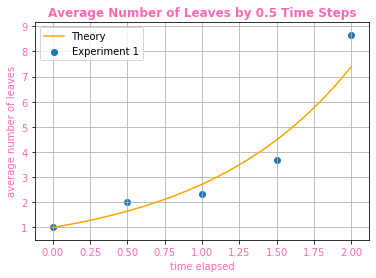

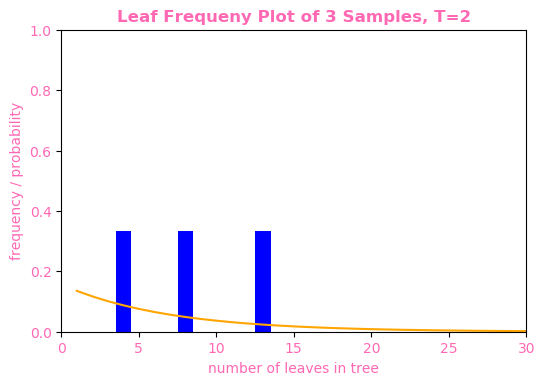

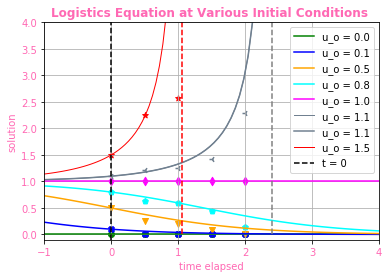

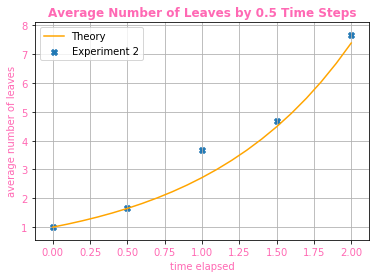

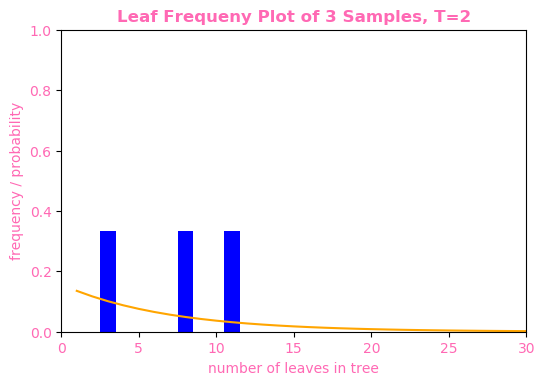

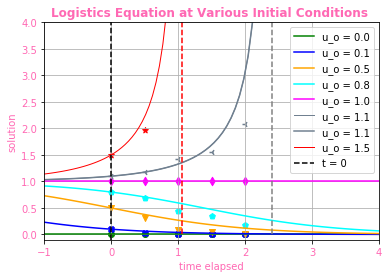

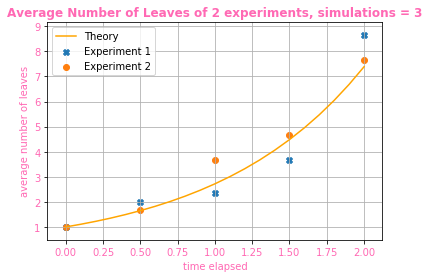

ValueError: operands could not be broadcast together with shapes (5,) (9,) 

In [35]:
# Main
print('total_max', theory_points, 't_width', t_width) # prints the parpameters chosen for convinience in lue of promting 
pdf = matplotlib.backends.backend_pdf.PdfPages("output.pdf")
solution_data = np.array([]) #average of number of leaves
results_shown = np.array([])
for i in range (comparison_points):
    initiate_arrays()
    for z in range (num_iterations):
        initialize() # Setting Initial Parameters
        start_time = time() # # Record when computation will start, as an extra safety to prevent infinite while loop 
        base_case() # initialize base case
        while ((time() - start_time) < t_safe):
            iterative_loop()
            if int(lev[-1]) == 0:
                break
        buckets() 
        count_leaves() # need to add nodes non_last_gen_ended vs last_gen_ ended. 
        evolution_tree(z)
        #yule_process_ind(z) # Want the average
    yule_process(i)
    probability_plot()
    theory_plot()
pdf.close()    
yule_process_comp()
theory_plot_comp()    
      




In [4]:
pip install GitPython

Note: you may need to restart the kernel to use updated packages.
